In [2]:
import numpy    as np
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt
from time import time

from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics         import accuracy_score, balanced_accuracy_score, plot_confusion_matrix

from sklearn.linear_model  import LogisticRegression
from sklearn.naive_bayes   import GaussianNB
from sklearn.svm           import SVC
from sklearn.neighbors     import KNeighborsClassifier
from sklearn.tree          import DecisionTreeClassifier
from sklearn.ensemble      import RandomForestClassifier
from sklearn.ensemble      import ExtraTreesClassifier
from sklearn.ensemble      import AdaBoostClassifier
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.ensemble      import HistGradientBoostingClassifier
from xgboost               import XGBClassifier
from lightgbm              import LGBMClassifier
from catboost              import CatBoostClassifier

np.random.seed(0)

## Load Data

![title](./heart_dataset_description.jpg)

In [3]:
df = pd.read_csv('./heart.csv')
# df.dtypes
# df.isnull().sum()
# df.shape
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Data Visualisation

<AxesSubplot:>

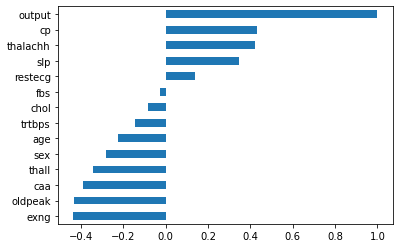

In [3]:
df.corr()['output'].sort_values().plot.barh()

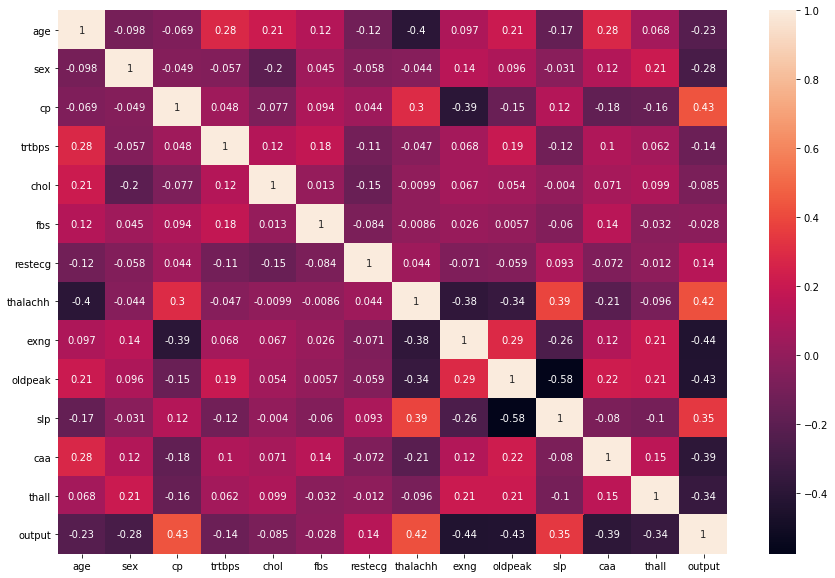

In [4]:
plt.figure(figsize=(15,10))
sb.heatmap(df.corr(), annot=True)
plt.show()

## Data Enhancement & Preprocessing

In [5]:
cat_cols = ['sex','cp','fbs','restecg','exng','slp','caa','thall']
num_cols = ['age','trtbps','chol','thalachh','oldpeak']

In [4]:
def data_enhancement(data):
    
    gen_data = data.copy()
    
    for i in data['cp'].unique():
        chest_pain_type =  gen_data[gen_data['cp'] == i]
        age = chest_pain_type['age'].std()
        trtbps = chest_pain_type['trtbps'].std()
        chol = chest_pain_type['chol'].std()
        thalachh = chest_pain_type['thalachh'].std()
        oldpeak = chest_pain_type['oldpeak'].std()
        
        for j in gen_data[gen_data['cp'] == i].index:
            if np.random.randint(2) == 1:
                gen_data['age'].values[i] += age/10
            else:
                gen_data['age'].values[i] -= age/10
                
            if np.random.randint(2) == 1:
                gen_data['trtbps'].values[i] += trtbps/10
            else:
                gen_data['trtbps'].values[i] -= trtbps/10
                
            if np.random.randint(2) == 1:
                gen_data['chol'].values[i] += chol/10
            else:
                gen_data['chol'].values[i] -= chol/10

            if np.random.randint(2) == 1:
                gen_data['thalachh'].values[i] += thalachh/10
            else:
                gen_data['thalachh'].values[i] -= thalachh/10
                
            if np.random.randint(2) == 1:
                gen_data['oldpeak'].values[i] += oldpeak/10
            else:
                gen_data['oldpeak'].values[i] -= oldpeak/10

    return gen_data

gen = data_enhancement(df)


In [6]:
# Set x and y, and split them
y = df['output']
x = df.drop(['output', 'oldpeak', 'slp', 'thall'], axis=1)

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=0)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,caa
0,63,1,3,145,233,1,0,150,0,0
1,37,1,2,130,250,0,1,187,0,0
2,41,0,1,130,204,0,0,172,0,0
3,56,1,1,120,236,0,1,178,0,0
4,57,0,0,120,354,0,1,163,1,0


In [8]:
# ADD the generated data
extra_sample = gen.sample(gen.shape[0] // 4)
x_train = pd.concat([x_train, extra_sample.drop(['output', 'oldpeak', 'slp', 'thall'], axis=1)])
y_train = pd.concat([y_train, extra_sample['output']])

## Data Scaling

In [9]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

## Models tested

In [10]:
tree_classifiers = {
  "Support Vector Classifier": SVC(),
  "LogisticRegression": LogisticRegression(),
  "Gaussian Naive Bayes": GaussianNB(),
  "k-NN": KNeighborsClassifier(),
  "Decision Tree": DecisionTreeClassifier(),
  "Extra Trees": ExtraTreesClassifier(verbose=False),
  "Random Forest": RandomForestClassifier(verbose=False),
  "AdaBoost": AdaBoostClassifier(),
  "Skl GBM": GradientBoostingClassifier(verbose=False),
  "Skl HistGBM": HistGradientBoostingClassifier(verbose=False),
  "XGBoost": XGBClassifier(use_label_encoder=False, verbosity=0),
  "LightGBM": LGBMClassifier(),
  "CatBoost": CatBoostClassifier(verbose=False)
}

In [11]:
results = pd.DataFrame({'Model': [], 
                        'Accuracy': [], 
                        'Bal Acc.': [], 
                        'Time': []})

for model_name, model in tree_classifiers.items():
        start_time = time()

        model.fit(x_train, y_train)

        pred = model.predict(x_val)

        total_time = time() - start_time
        print(f'Finished {model_name}')

        results = results.append({"Model":  model_name,
                                "Accuracy": accuracy_score(y_val, pred)*100,
                                "Bal Acc.": balanced_accuracy_score(y_val, pred)*100,
                                "Time":     total_time}, 
                                ignore_index=True)

results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord

Finished Support Vector Classifier
Finished LogisticRegression
Finished Gaussian Naive Bayes
Finished k-NN
Finished Decision Tree
Finished Extra Trees
Finished Random Forest
Finished AdaBoost
Finished Skl GBM
Finished Skl HistGBM
Finished XGBoost
Finished LightGBM
Finished CatBoost


,Model,Accuracy,Bal Acc.,Time
0,Extra Trees,91.803279,91.122004,0.096743
1,AdaBoost,91.803279,91.884532,0.072766
2,Support Vector Classifier,90.163934,90.032680,0.005952
3,Random Forest,90.163934,90.032680,0.141626
4,Skl HistGBM,90.163934,90.032680,0.361003
5,CatBoost,90.163934,90.032680,1.343611
6,Skl GBM,88.524590,88.943355,0.079782
7,XGBoost,88.524590,88.562092,0.082779
8,LightGBM,88.524590,88.562092,0.037898
9,LogisticRegression,86.885246,86.328976,0.002990


## Grid Search

#### RandomForestClassifier

In [12]:
rfc_params = {"max_depth": [2,4,6,8,10],"max_features": [2,4,6,8,10],"n_estimators": [10,500,1000],"min_samples_split": [2,4,6,8,10]}
rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc, rfc_params, cv=10, n_jobs=-1, verbose=2)
rfc_grid.fit(x_train, y_train)
print("Best params: " + str(rfc_grid.best_params_))

Fitting 10 folds for each of 375 candidates, totalling 3750 fits
Best params: {'max_depth': 10, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 500}


In [24]:
rfc_tuned = RandomForestClassifier(max_depth=10, max_features=2, min_samples_split=2, n_estimators=500)
rfc_tuned.fit(x_train, y_train)
preds_rfc_tuned = rfc_tuned.predict(x_val)
accuracy_score(y_val, preds_rfc_tuned)

0.9180327868852459

#### k-NN

In [14]:
knn_params = {"leaf_size" : [10,20,30,40,50,60],"n_neighbors" : [10,20,30,40,50,60],"p": [1,2]}
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_params, cv=10)
knn_grid.fit(x_train, y_train)
print("Best params: " + str(knn_grid.best_params_))

Best params: {'leaf_size': 10, 'n_neighbors': 20, 'p': 2}


In [15]:
knn_tuned = KNeighborsClassifier(leaf_size=10, n_neighbors=20, p=2)
knn_tuned.fit(x_train, y_train)
preds_knn_tuned = knn_tuned.predict(x_val)
accuracy_score(y_val, preds_knn_tuned)

0.8688524590163934

#### SVC

In [16]:
svc_params={"C": [0.1,1, 10, 100], "gamma": [1,0.1,0.01,0.001],"kernel": ['rbf', 'poly', 'sigmoid']}
svc = SVC()
svc_grid = GridSearchCV(svc, svc_params, cv=10, n_jobs=-1, verbose=2)
svc_grid.fit(x_train, y_train)
print("Best params: " + str(svc_grid.best_params_))

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Best params: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


In [17]:
svc_tuned = SVC(C=100, gamma=0.1, kernel='rbf')
svc_tuned.fit(x_train, y_train)
preds_svc_tuned = svc_tuned.predict(x_val)
accuracy_score(y_val, preds_svc_tuned)

0.9016393442622951

#### ExtraTreesClassifier

In [18]:
etc_params = {"max_depth": [2,4,6,8,10],"max_features": [2,4,6,8,10],"n_estimators": [10,250,500,1000],"min_samples_split": [2,4,6,8,10]}
etc = ExtraTreesClassifier()
etc_grid = GridSearchCV(etc, etc_params, cv=10, n_jobs=-1, verbose=2)
etc_grid.fit(x_train, y_train)
print("Best params: " + str(etc_grid.best_params_))

Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Best params: {'max_depth': 10, 'max_features': 6, 'min_samples_split': 4, 'n_estimators': 500}


In [19]:
etc_tuned = ExtraTreesClassifier(max_depth=10, max_features=6, min_samples_split=4, n_estimators=500)
etc_tuned.fit(x_train, y_train)
preds_etc_tuned = etc_tuned.predict(x_val)
accuracy_score(y_val, preds_etc_tuned)

0.9344262295081968

#### AdaBoostClassifier

In [20]:
ada_params = {"n_estimators": [10,100,250,500], "learning_rate":[0.1,1,10,100]}
ada = AdaBoostClassifier()
ada_grid = GridSearchCV(ada, ada_params, cv=10, n_jobs=-1, verbose=2)
ada_grid.fit(x_train, y_train)
print("Best params: " + str(ada_grid.best_params_))

Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best params: {'learning_rate': 1, 'n_estimators': 100}


In [21]:
ada_tuned = AdaBoostClassifier(n_estimators=100)
ada_tuned.fit(x_train, y_train)
preds_ada_tuned = ada_tuned.predict(x_val)
accuracy_score(y_val, preds_ada_tuned)

0.9016393442622951

#### HistGradientBoostingClassifier

In [22]:
hgbc_params = {"learning_rate":[0.1,1,10,100], "max_iter":[10,50,100,200,500],"max_depth": [2,4,6,8,10]}
hgbc = HistGradientBoostingClassifier()
hgbc_grid = GridSearchCV(hgbc, hgbc_params, cv=10, n_jobs=-1, verbose=2)
hgbc_grid.fit(x_train, y_train)
print("Best params: " + str(hgbc_grid.best_params_))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best params: {'learning_rate': 0.1, 'max_depth': 8, 'max_iter': 100}


In [23]:
hgbc_tuned = HistGradientBoostingClassifier(max_depth=8)
hgbc_tuned.fit(x_train, y_train)
preds_hgbc_tuned = hgbc_tuned.predict(x_val)
accuracy_score(y_val, preds_hgbc_tuned)

0.9016393442622951

### ExtraTreesClassifier got the best results with 93.4% accuracy